In [1]:
import pandas as pd

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [2]:
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
from sklearn.preprocessing import LabelEncoder

for col in list(train_df):
    if col in ['Name', 'Cabin', 'Ticket']:
        continue
    if train_df[col].dtype == 'O':
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col] = test_df[col].fillna('unseen_before_label')
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        le = LabelEncoder()
        le.fit(train_df[col])
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])

In [4]:
test_df.head()

PassengerId  Pclass                                          Name  Sex  \
0          892       3                              Kelly, Mr. James    1   
1          893       3              Wilkes, Mrs. James (Ellen Needs)    0   
2          894       2                     Myles, Mr. Thomas Francis    1   
3          895       3                              Wirz, Mr. Albert    1   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    0   

    Age  SibSp  Parch   Ticket     Fare Cabin  Embarked  
0  34.5      0      0   330911   7.8292   NaN         1  
1  47.0      1      0   363272   7.0000   NaN         2  
2  62.0      0      0   240276   9.6875   NaN         1  
3  27.0      0      0   315154   8.6625   NaN         2  
4  22.0      1      1  3101298  12.2875   NaN         2

In [5]:
import lightgbm as lgb
import seaborn as sns
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold

folds = StratifiedKFold(n_splits=2, shuffle=True, random_state=1001)
sub_preds = np.zeros(test_df.shape[0])
feats = [f for f in train_df.columns if f not in ['Survived', 'PassengerId', 'Name', 'Cabin', 'Ticket']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['Survived'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['Survived'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['Survived'].iloc[valid_idx]
    clf = LGBMClassifier(
                objective='binary',
                boosting_type='gbdt',
                metric='auc',
                n_jobs=-1,
                num_leaves=910,
                max_depth=-1,
                tree_learner='serial',
                colsample_bytree=0.7312219438641832,
                subsample_freq=4,
                subsample=0.8754761947091015,
                n_estimators=800,
                max_bin=255,
                verbose=-1,
                seed=42,
                learning_rate=0.07928065415431466
                )


    clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], early_stopping_rounds=100)
    
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
model_json = clf.booster_.dump_model()

[1]	training's auc: 0.87588	valid_1's auc: 0.799468
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.879402	valid_1's auc: 0.800447
[3]	training's auc: 0.892667	valid_1's auc: 0.832982
[4]	training's auc: 0.902602	valid_1's auc: 0.845901
[5]	training's auc: 0.910573	valid_1's auc: 0.847305
[6]	training's auc: 0.912889	valid_1's auc: 0.845508
[7]	training's auc: 0.90862	valid_1's auc: 0.852313
[8]	training's auc: 0.904971	valid_1's auc: 0.853546
[9]	training's auc: 0.909122	valid_1's auc: 0.857586
[10]	training's auc: 0.912345	valid_1's auc: 0.857023
[11]	training's auc: 0.914031	valid_1's auc: 0.859011
[12]	training's auc: 0.916784	valid_1's auc: 0.861627
[13]	training's auc: 0.917446	valid_1's auc: 0.860723
[14]	training's auc: 0.916592	valid_1's auc: 0.860766
[15]	training's auc: 0.916037	valid_1's auc: 0.860191
[16]	training's auc: 0.918598	valid_1's auc: 0.859979
[17]	training's auc: 0.918833	valid_1's auc: 0.860213
[18]	training's auc: 0.919836	

[1]	training's auc: 0.868783	valid_1's auc: 0.807167
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.873961	valid_1's auc: 0.838167
[3]	training's auc: 0.889006	valid_1's auc: 0.851912
[4]	training's auc: 0.896098	valid_1's auc: 0.849661
[5]	training's auc: 0.905529	valid_1's auc: 0.851389
[6]	training's auc: 0.906082	valid_1's auc: 0.850546
[7]	training's auc: 0.90571	valid_1's auc: 0.854431
[8]	training's auc: 0.905072	valid_1's auc: 0.855477
[9]	training's auc: 0.910154	valid_1's auc: 0.857526
[10]	training's auc: 0.913705	valid_1's auc: 0.856725
[11]	training's auc: 0.915141	valid_1's auc: 0.859414
[12]	training's auc: 0.915545	valid_1's auc: 0.86204
[13]	training's auc: 0.916502	valid_1's auc: 0.86363
[14]	training's auc: 0.914875	valid_1's auc: 0.863747
[15]	training's auc: 0.914428	valid_1's auc: 0.864313
[16]	training's auc: 0.917012	valid_1's auc: 0.865006
[17]	training's auc: 0.917055	valid_1's auc: 0.865134
[18]	training's auc: 0.918065	v

In [6]:
sub_preds

array([0.11765182, 0.22057426, 0.08069895, 0.19491283, 0.29480634,
       0.27791717, 0.57172242, 0.19368111, 0.75391251, 0.04297075,
       0.06025372, 0.27757859, 0.93436795, 0.08055493, 0.93631248,
       0.89145422, 0.13162443, 0.22273848, 0.46931439, 0.43817363,
       0.35400841, 0.28799026, 0.93084936, 0.48589669, 0.93693721,
       0.05764635, 0.9709779 , 0.22817841, 0.4344703 , 0.12444418,
       0.09682764, 0.06381726, 0.25529064, 0.40706174, 0.60293669,
       0.22886471, 0.4368915 , 0.35603946, 0.06680466, 0.35952675,
       0.12256823, 0.42027553, 0.10797396, 0.89195761, 0.92557277,
       0.13786114, 0.37848035, 0.10033244, 0.96037058, 0.47897677,
       0.45626133, 0.18788605, 0.80766754, 0.82221616, 0.25180414,
       0.14716235, 0.08890606, 0.10220783, 0.14259281, 0.97275762,
       0.114945  , 0.18125017, 0.1389749 , 0.73988587, 0.51199476,
       0.90731049, 0.74521707, 0.18085584, 0.50027037, 0.87249691,
       0.72567057, 0.05792524, 0.5682356 , 0.4695048 , 0.97377

In [7]:
model_json

{'name': 'tree',
 'version': 'v2',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 6,
 'average_output': False,
 'objective': 'binary sigmoid:1',
 'feature_names': ['Pclass',
  'Sex',
  'Age',
  'SibSp',
  'Parch',
  'Fare',
  'Embarked'],
 'tree_info': [{'tree_index': 0,
   'num_leaves': 16,
   'num_cat': 0,
   'shrinkage': 1,
   'tree_structure': {'split_index': 0,
    'split_feature': 1,
    'split_gain': 103.57099914550781,
    'threshold': 1.0000000180025095e-35,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 0,
    'internal_count': 390,
    'left_child': {'split_index': 1,
     'split_feature': 5,
     'split_gain': 14.633899688720703,
     'threshold': 25.5271,
     'decision_type': '<=',
     'default_left': True,
     'missing_type': 'None',
     'internal_value': 1.4166400000000001,
     'internal_count': 142,
     'left_child': {'split_index': 6,
      'split_feature': 2,
      'sp

In [14]:
train_df[feats].columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [84]:
import seaborn as sns

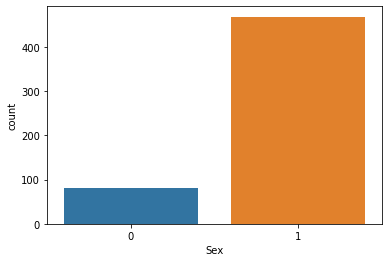

In [93]:
sns.countplot(train_df[train_df['Survived'] == 0]['Sex'])

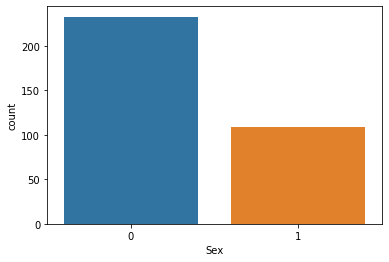

In [92]:
sns.countplot(train_df[train_df['Survived'] == 1]['Sex'])

In [12]:
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 62.00000
Feature: 1, Score: 46.00000
Feature: 2, Score: 284.00000
Feature: 3, Score: 41.00000
Feature: 4, Score: 19.00000
Feature: 5, Score: 316.00000
Feature: 6, Score: 47.00000


In [15]:
len(model_json['tree_info'])

60

In [17]:
d = model_json['tree_info']

In [68]:
aa = []
bb = []

In [69]:
def rec_dict(d):
    global aa
    global bb
    feature = d.get('split_feature', '')
    for dd in d:
        if dd == 'split_gain':
            val = d[dd]
            aa.append(feature)
            bb.append(val)
        if dd == 'tree_structure':
            rec_dict(d[dd])
        if dd == 'left_child':
            rec_dict(d[dd])
        if dd == 'right_child':
            rec_dict(d[dd])

In [70]:
for a in d:
    rec_dict(a)

In [75]:
d_df = pd.DataFrame({'feature': aa, 'val': bb})

In [78]:
sorted_df = d_df.sort_values(by='val', ascending=False)

In [83]:
sorted_df.groupby(['feature'])['val'].sum()

feature
0    338.080626
1    725.245604
2    408.610107
3     68.879976
4     33.521064
5    448.452418
6     72.848031
Name: val, dtype: float64

In [94]:
sorted_df.groupby(['feature'])['val'].count()

feature
0     62
1     46
2    284
3     41
4     19
5    316
6     47
Name: val, dtype: int64

In [95]:
importance

array([ 62,  46, 284,  41,  19, 316,  47])

In [ ]:
lgb.create_tree_digraph(clf.booster_)